# 0: Accessing data (via Google Drive)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!mkdir data
!cp -r /content/drive/MyDrive/store_sales_data/ data/
!ls data/store_sales_data

holidays_events.csv  sample_submission.csv  test.csv   transactions.csv
oil.csv		     stores.csv		    train.csv


# 1: Inspecting raw data

## Read in raw data

In [47]:
# Read in data

import os
import pandas as pd

data_path = "data/store_sales_data/"

dfs = {}

dfs['holidays_events'] = pd.read_csv(os.path.join(data_path, "holidays_events.csv"))
dfs['oil'] = pd.read_csv(os.path.join(data_path, "oil.csv"))
dfs['stores'] = pd.read_csv(os.path.join(data_path, "stores.csv"))
dfs['train'] = pd.read_csv(os.path.join(data_path, "train.csv"))
dfs['test'] = pd.read_csv(os.path.join(data_path, "test.csv"))

We have a normalized setup of our data

## Basic inspection of data

In [57]:
# Check out our df shapes
def inspect_df(df_name, df):
    print(f" * {df_name}.dtypes: \n{df.dtypes}")
    print(f" * {df_name}.isnull().sum(): \n{df.isnull().sum()}")
    print(f" * {df_name}.shape: {df.shape}")
    print(f" * {df_name}.nunique() : \n{df.nunique()}")

for i, df_name in enumerate(dfs):
    print(f"\n#### {i+1}/{len(dfs)}: {df_name} ####")
    df = dfs[df_name]
    inspect_df(df_name, df)


#### 1/5: holidays_events ####
 * holidays_events.dtypes: 
date           object
type           object
locale         object
locale_name    object
description    object
transferred      bool
dtype: object
 * holidays_events.isnull().sum(): 
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64
 * holidays_events.shape: (350, 6)
 * holidays_events.nunique() : 
date           312
type             6
locale           3
locale_name     24
description    103
transferred      2
dtype: int64

#### 2/5: oil ####
 * oil.dtypes: 
date           object
dcoilwtico    float64
dtype: object
 * oil.isnull().sum(): 
date           0
dcoilwtico    43
dtype: int64
 * oil.shape: (1218, 2)
 * oil.nunique() : 
date          1218
dcoilwtico     998
dtype: int64

#### 3/5: stores ####
 * stores.dtypes: 
store_nbr     int64
city         object
state        object
type         object
cluster       int64
dtype: object
 * stores.isnull().sum(): 
store_

What we deduce from above:
* Basically no N/A's, only in oil
* No duplicate rows

In [56]:
# For getting a better idea of what our data looks like
for i, df_name in enumerate(dfs):
    print(f"\n#### {i+1}/{len(dfs)}: {df_name} ####")
    df = dfs[df_name]

    print(df.head())


#### 1/5: holidays_events ####
         date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False  

#### 2/5: oil ####
         date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02       93.14
2  2013-01-03       92.97
3  2013-01-04       93.12
4  2013-01-07       93.20

#### 3/5: stores ####
   store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                 

# CLEAN DATA

## Visualization of features


#### 1/5: holidays_events ####
Histograms of numerical data: 


<Figure size 1000x0 with 0 Axes>

Barplots of categorical data: 


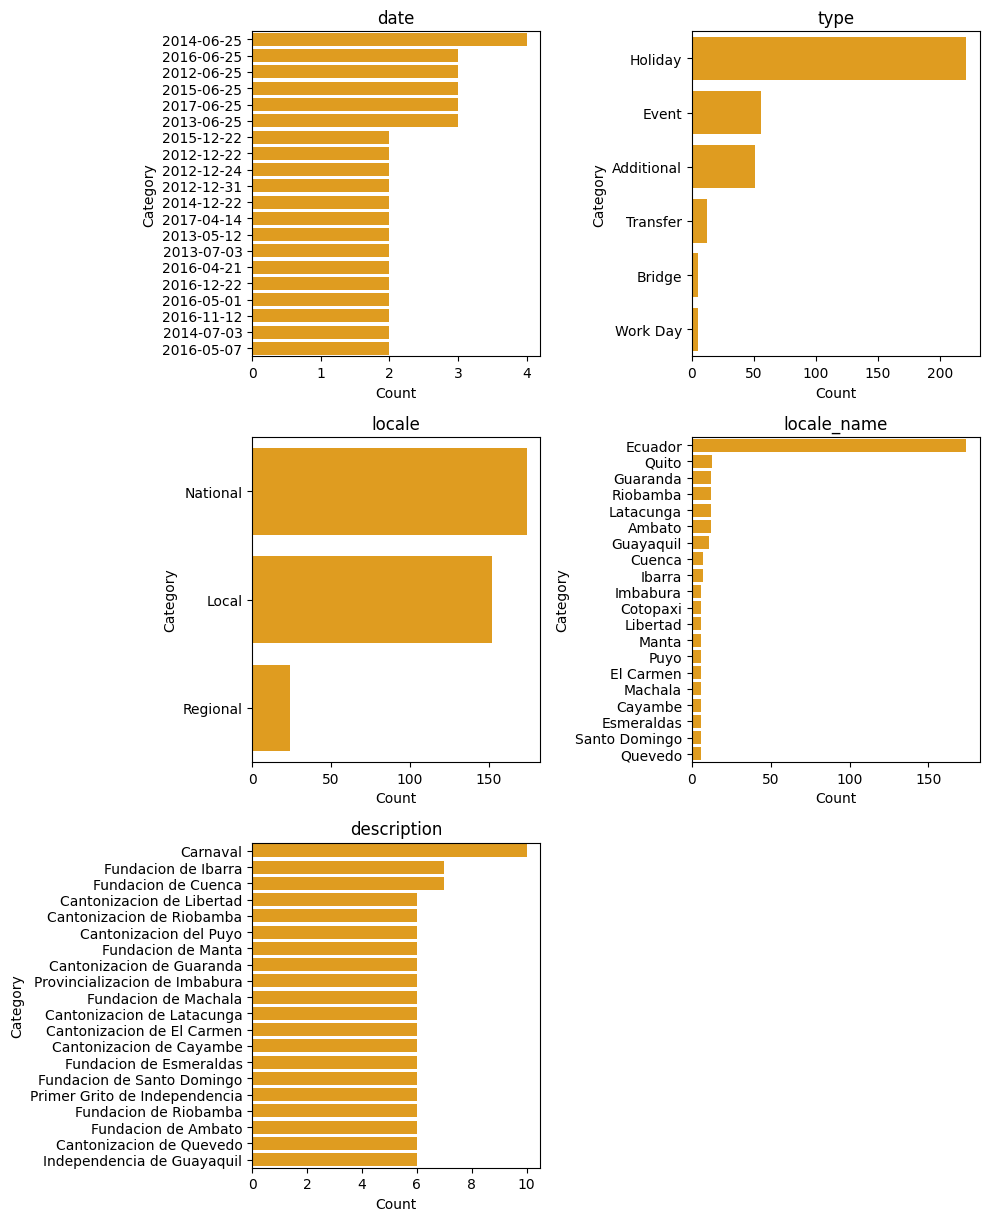


#### 2/5: oil ####
Histograms of numerical data: 


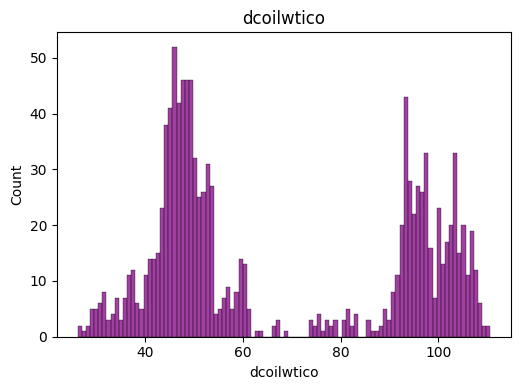

Barplots of categorical data: 


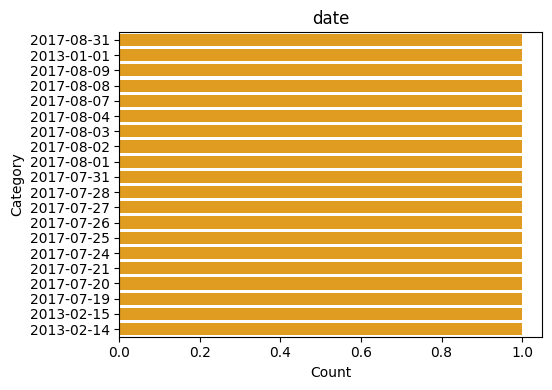


#### 3/5: stores ####
Histograms of numerical data: 


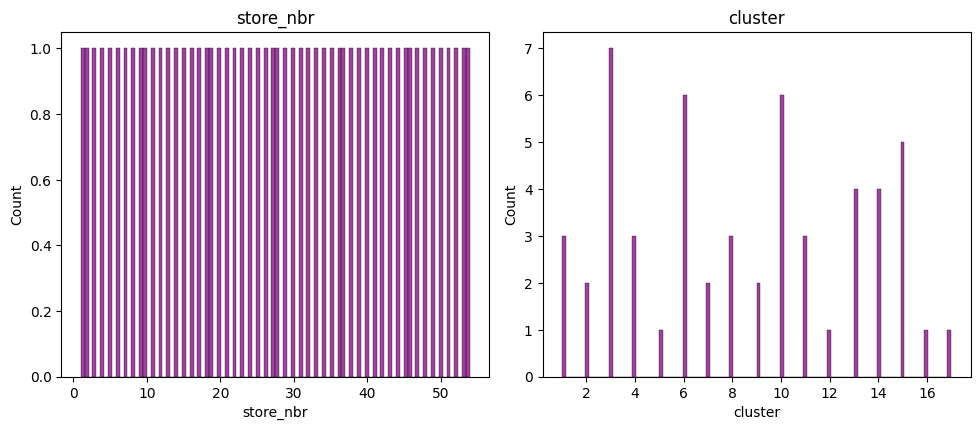

Barplots of categorical data: 


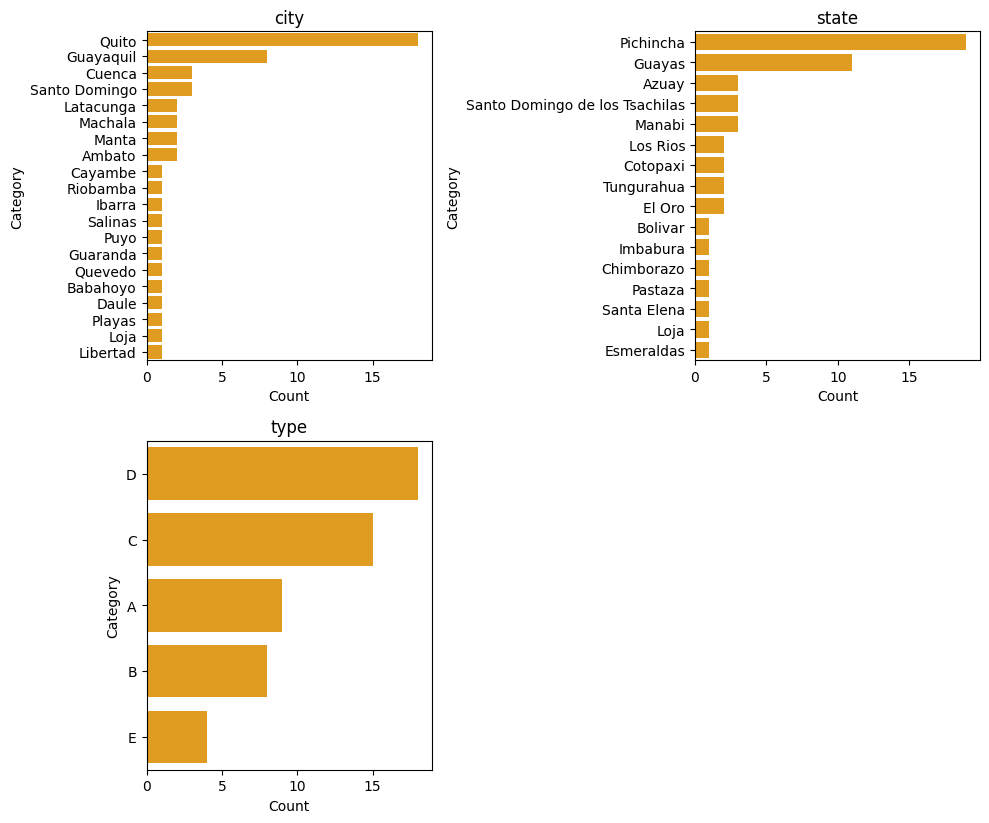


#### 4/5: train ####
Histograms of numerical data: 


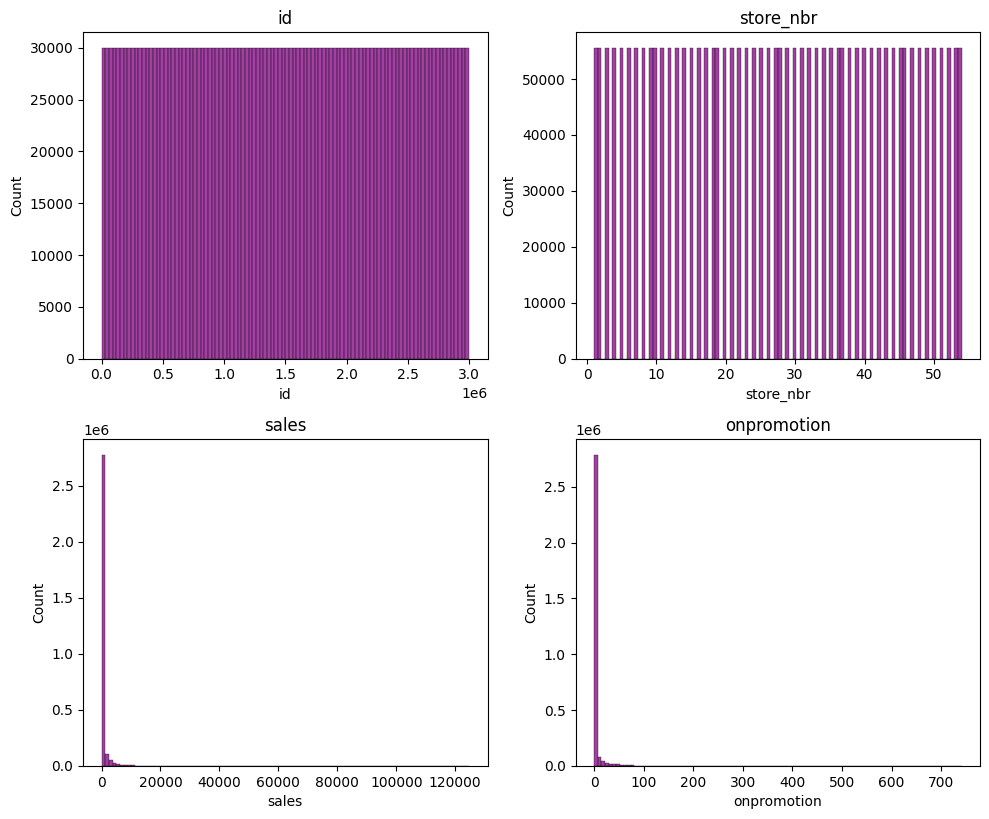

Barplots of categorical data: 


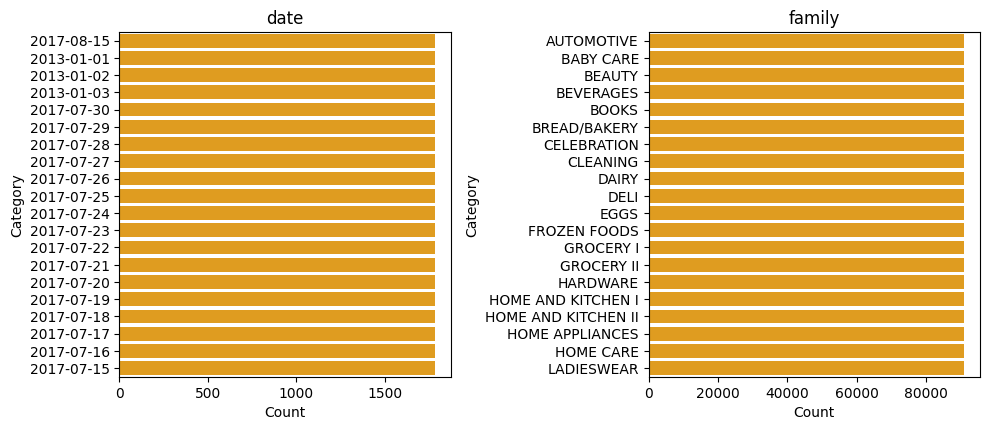


#### 5/5: test ####
Histograms of numerical data: 


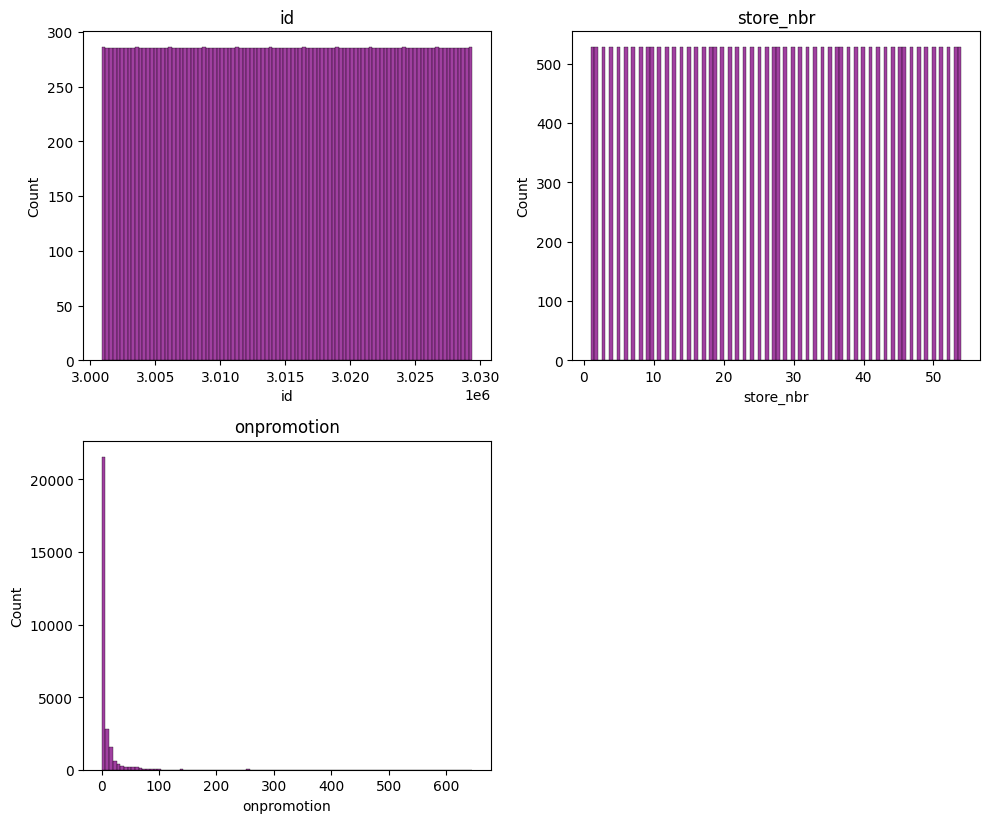

Barplots of categorical data: 


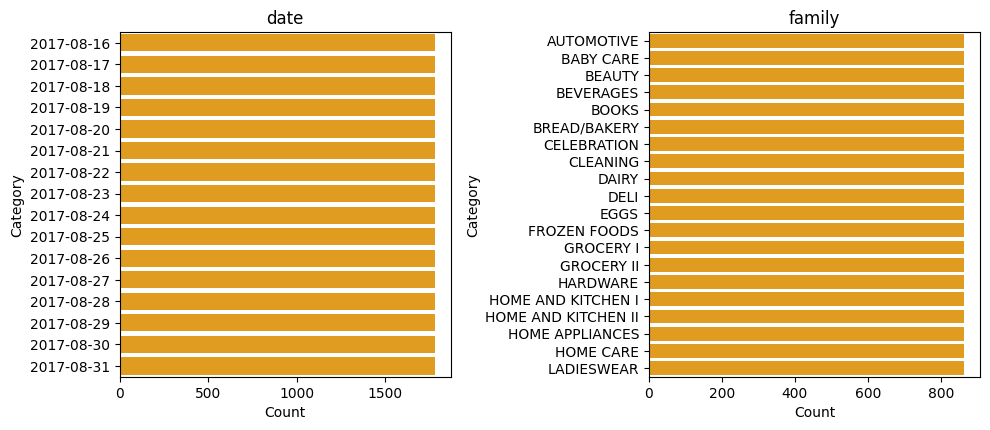

In [52]:
# Univariate visualizations

# Make histogram of each numerical column
# Make bar plot of each categorical column
import seaborn as sns
import matplotlib.pyplot as plt


def make_histograms(df_name, df):
    numeric_cols = df.select_dtypes(include='number').columns

    # Set up the layout
    n_rows = len(numeric_cols)
    plt.figure(figsize=(10, 4 * n_rows))

    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(n_rows, 2, i)
        sns.histplot(df[col].dropna(), bins=100, color='purple')
        plt.title(col)

    plt.tight_layout()
    plt.show()


def make_barplots(df_name, df):
    object_cols = df.select_dtypes(include='object').columns
    n_rows = len(object_cols)
    plt.figure(figsize=(10, 4 * n_rows))

    for i, col in enumerate(object_cols, 1):
        plt.subplot(n_rows, 2, i)
        counts = df[col].value_counts().head(20)  # top 20 categories
        sns.barplot(x=counts.values, y=counts.index, orient='h', color='orange')
        plt.title(col)
        plt.xlabel("Count")
        plt.ylabel("Category")

    plt.tight_layout()
    plt.show()


for i, df_name in enumerate(dfs):
    print(f"\n#### {i+1}/{len(dfs)}: {df_name} ####")
    df = dfs[df_name]

    print(f"Histograms of numerical data: ")
    make_histograms(df_name, df)
    print(f"Barplots of categorical data: ")
    make_barplots(df_name, df)

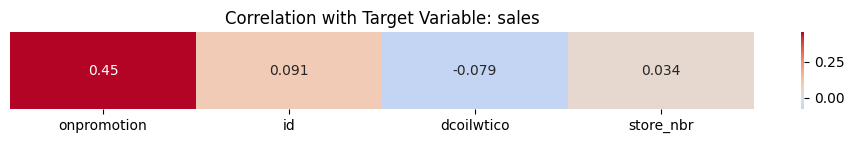

In [58]:
# Heat map against the target variable
def corr_heatmap_against_target(df, target_col='sales'):
    # Compute correlations with the target variable
    correlation = df.corr(numeric_only=True)[target_col].drop(target_col)
    correlation = correlation.reindex(correlation.abs().sort_values(ascending=False).index)

    # Convert to DataFrame for seaborn heatmap
    correlation_df = correlation.to_frame().T  # make it a row to heatmap it horizontally

    # Plot the heatmap
    plt.figure(figsize=(12, 1))  # Adjust height to make it thin
    sns.heatmap(correlation_df, annot=True, cmap='coolwarm', center=0)
    plt.title(f'Correlation with Target Variable: {target_col}')
    plt.yticks([])  # optional: hides the y-axis (since it's just one row)
    plt.show()

corr_heatmap_against_target(pd.merge(dfs['train'], dfs['oil'], on='date'))

# None of the other features are numeric!

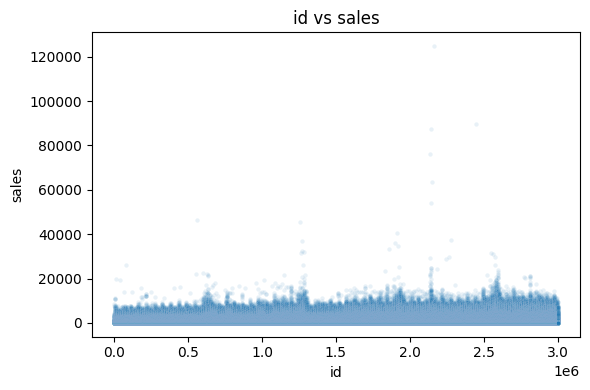

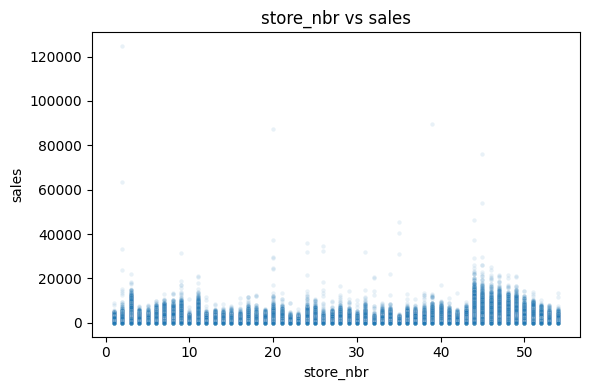

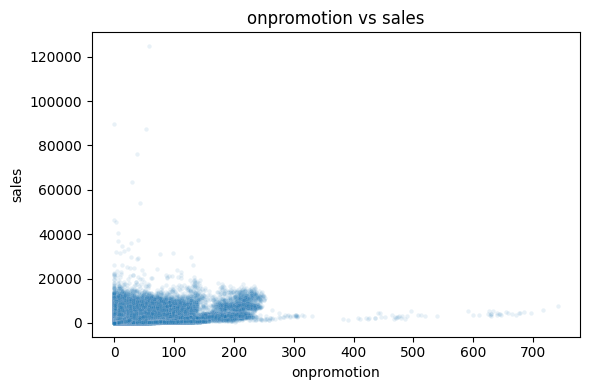

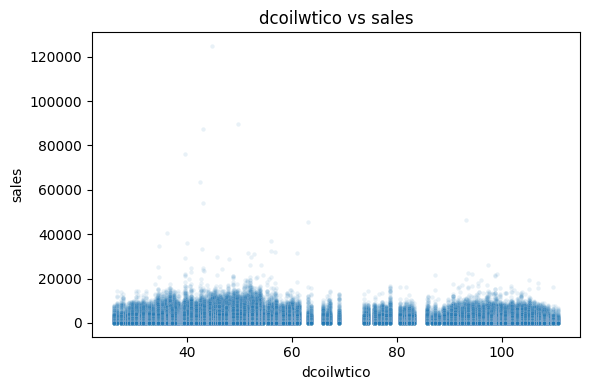

In [62]:
# Scatter plots of numerical features against target variable
def scatter_plot_against_target(df, target_col='sales'):
    # Loop through each numerical feature
    for col in df.select_dtypes(include='number').columns:
        if col == target_col:
            continue  # skip the target itself

        plt.figure(figsize=(6, 4))
        sns.scatterplot(data=df, x=col, y=target_col, alpha=0.1, s=10)
        plt.title(f'{col} vs {target_col}')
        plt.xlabel(col)
        plt.ylabel(target_col)
        plt.tight_layout()
        plt.show()

scatter_plot_against_target(pd.merge(dfs['train'], dfs['oil'], on='date'))

* Ensure no duplicate rows

* Missing data/Imputation Strategy:
    * sns.heatmap(df.isnull())
    * Figure out whether to drop or impute

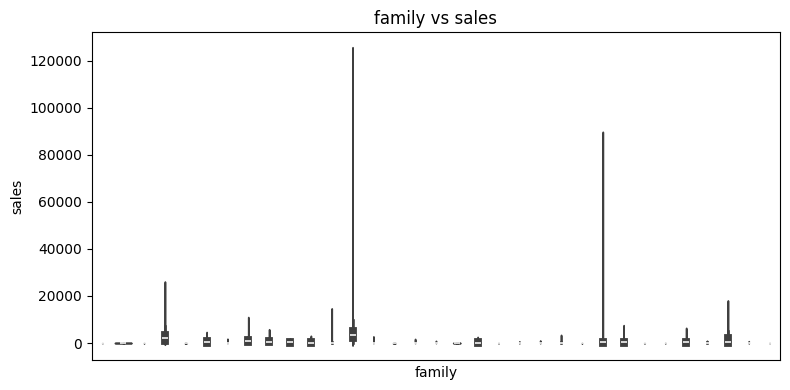

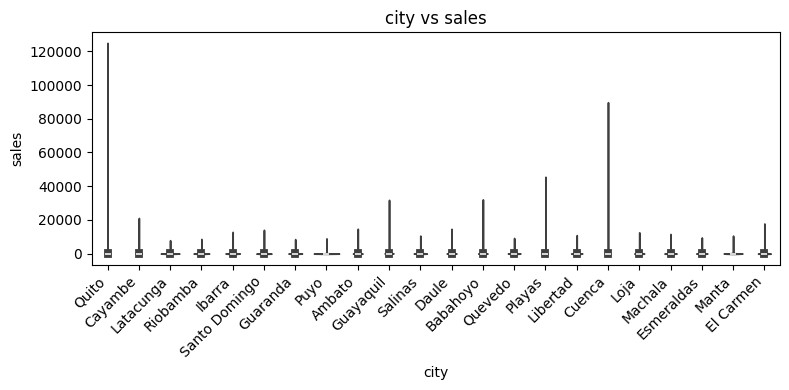

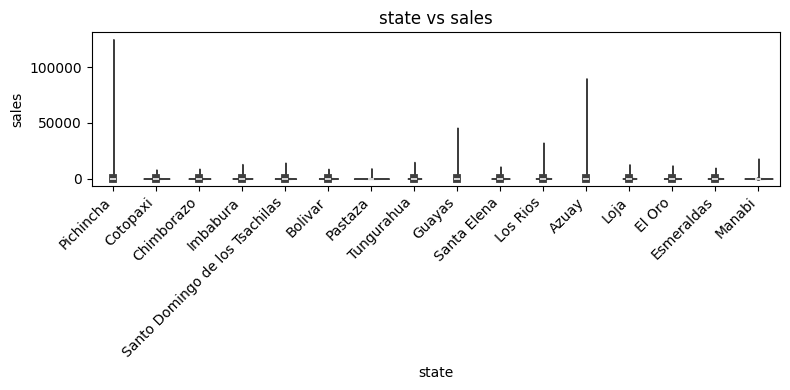

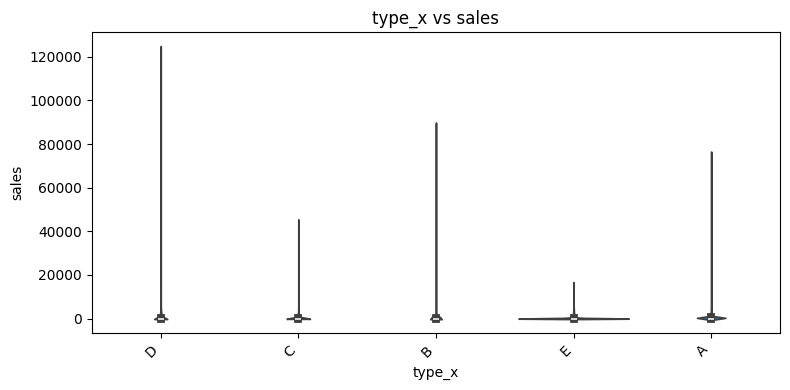

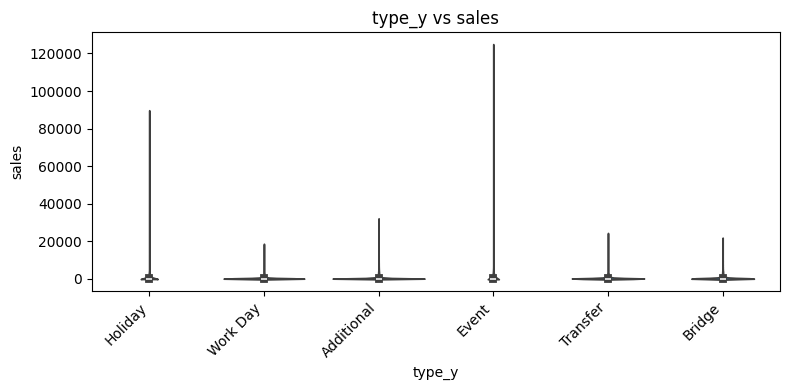

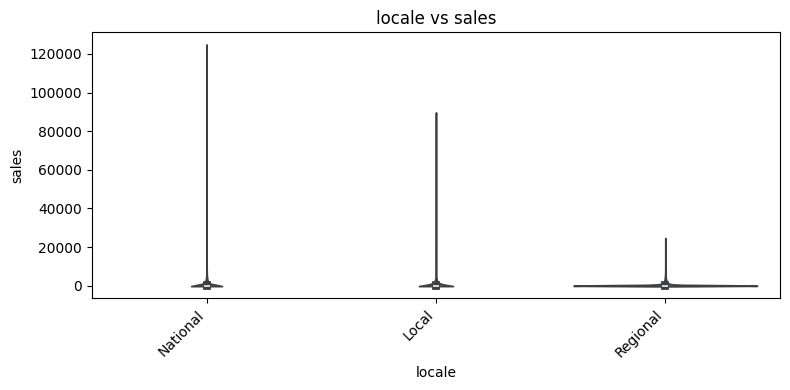

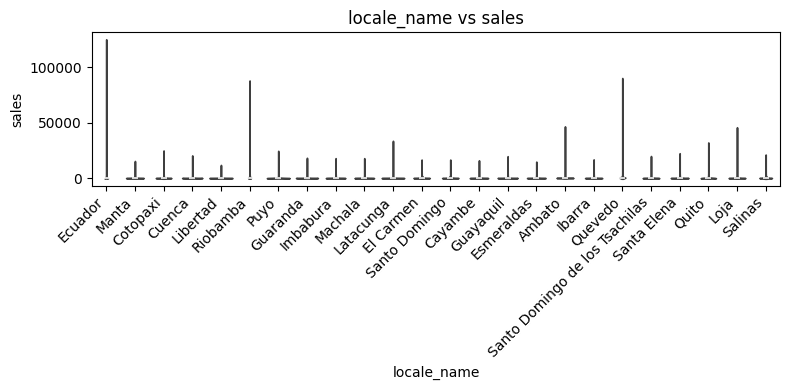

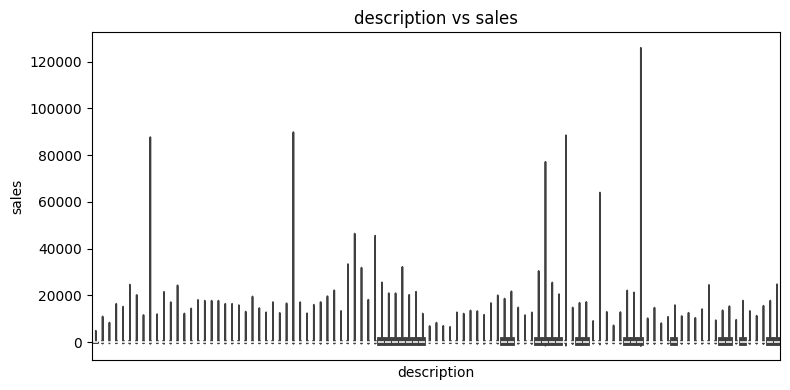

In [70]:
def boxplot_against_target(df, target_col='sales', max_labels=25):
    # Loop through categorical columns
    for col in df.select_dtypes(include='object').columns:
        num_categories = df[col].nunique()
        plt.figure(figsize=(8, 4))
        sns.violinplot(data=df, x=col, y=target_col)
        plt.title(f'{col} vs {target_col}')
        if num_categories > max_labels:
            plt.xticks([], [])  # completely remove x-axis labels and ticks
        else:
            plt.xticks(rotation=45, ha='right')  # otherwise rotate labels
        plt.tight_layout()
        plt.show()


df = pd.merge(dfs['train'], dfs['stores'], on='store_nbr')
df = pd.merge(df, dfs['holidays_events'], on='date')

boxplot_against_target(df.drop(columns=['date']))

#2: EDA with Clean Data

TODO:

A: Univariate Analysis
* Plot histogram of numerical data
* Plot histogram (bar plot) of categorical data
* Use .describe() to find out what's going on with numerical data
* Identify outliers for numerical data

B: Bivariate Analysis
* Correlation heatmap of numerical data with target
* Scatter plots of numerical data with target
* Boxplot of categorical with target (???)

C: Multivariate Analysis (maybe not)
* Pairplots?
* Dimensionality reduction (PCA, t-SNE)?

D: Data quality checks
* No duplicate rows?
* Inconsistent categories?
* Correct time ranges?
* Out-of-range values?

E: Target Variable Analysis
* Numerical: Distribution? Skew? Outliers?
* Categorical: Class balance?
